# Collaborative Filtering for Tabelog (食べログ)

Use user ratings of selected restaurants / stores to impute missing ratings, then use the completed data to give an estimate for the overall rating, food rating, service rating, atmosphere rating, price rating, and drink rating.

Translations and columns:
- 料理・味 - Food and taste - food
- サービス - Service - service
- 雰囲気 - Atmosphere - atmosphere
- CP - Cost Performance (price) - cp
- 酒・ドリンク - Alcohol and drink - drink

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from util import print_debug

In [28]:
restaurant_data = pd.read_csv('./data/tabelog_review_data/tabelog_鎌倉のごはんやさん_石渡_review_data.csv')
restaurant_data.head()

,user_id,overall_rating,food,service,atmosphere,price,drink
0,1,4.0,NaN,NaN,NaN,NaN,NaN
1,2,5.0,5.0,5.0,5.0,5.0,4.0
2,3,3.5,NaN,NaN,NaN,NaN,NaN
3,4,3.4,NaN,NaN,NaN,NaN,NaN
4,5,3.0,NaN,NaN,NaN,NaN,NaN


In [29]:
original_ratings = np.array(restaurant_data.iloc[:, 1:].values, dtype=float)

In [30]:
user_ids1 = restaurant_data['user_id'].values
ratings1 = restaurant_data.iloc[:, 1:].values
category_names1 = restaurant_data.columns[1:]

In [31]:
def cosine_similarity(i1: np.array, i2: np.array):
    """
    Calculate the cosine similarity between two items
    :param i1: Item 1
    :param i2: Item 2
    :return: Cosine similarity (0, 1)
    """
    # Create condition where either i1 or i2 has a value that isn't NaN
    shared = ~np.isnan(i1) & ~np.isnan(i2)
    
    # Items with only shared values
    i1_common, i2_common = i1[shared], i2[shared]
    
    # Calculate dot product and norms
    dot_product = np.dot(i1_common, i2_common)
    norm_i1 = np.sqrt(np.sum(i1_common**2))
    norm_i2 = np.sqrt(np.sum(i2_common**2))
    
    # In case division by zero happens
    if norm_i1 == 0 or norm_i2 == 0:
        return 0
        
    return dot_product / (norm_i1 * norm_i2)

def minmax_scale(x):
    """MinMax scale a row or column"""
    min_val = np.nanmin(x)
    max_val = np.nanmax(x)
    if max_val == min_val:
        return np.zeros_like(x)
    return (x - min_val) / (max_val - min_val)

In [32]:
class TabelogCollaborativeFilter:
    def __init__(self, ratings: np.array, category_names, user_ids: np.array, k: int = 4, debug: bool = False):
        """
        Constructor for TabelogCollaborativeFilter 
        :param ratings: Ratings of the items from the users only
        :param category_names: Category names (items)
        :param user_ids: User IDs
        :param k: Number of closest items to consider
        :param debug: Debug toggle
        """
        self.ratings = ratings
        self.category_names = category_names
        self.user_ids = user_ids
        self.k = k
        self.debug = debug
        self.__scaled_sim_scores = []
        self.__item_means = []
        self.__centered_ratings = np.full_like(ratings, np.nan)
        self.item_similarities = []
        
    def get_ssc(self):
        return self.__scaled_sim_scores
    
    def predict_and_impute(self) -> (pd.DataFrame, dict):
        # Run item-item CF
        self.__item_item_cf(self.ratings, self.category_names)
        # scaled_sim_scores = self.__item_item_cf(self.ratings, self.category_names)
        pred_ratings = self.predict_all_ratings()
        # Create a DataFrame with the predicted and imputed values
        imputed_df = pd.DataFrame(pred_ratings, columns=self.category_names)
        # Re-add user ids back
        imputed_df.insert(0, 'user_id', self.user_ids)
        
        print_debug("\nImputed DataFrame preview:", debug=self.debug)
        print_debug(imputed_df.head(), debug=self.debug)
        
        # Calculate mean ratings for each category after imputation
        category_mean_ratings = {}
        print_debug("\nMean ratings for each category after imputation:", debug=self.debug)
        for i, category in enumerate(self.category_names):
            mean_rating = np.mean(pred_ratings[:, i])
            # Add to dict
            category_mean_ratings[category] = round(mean_rating, 1)
            print_debug(f"{category}: {mean_rating:.2f}", debug=self.debug)
        return imputed_df, category_mean_ratings
    
    def __item_item_cf(self, ratings, category_names):
        """
        Run item-item collaborative filtering given the ratings, categories, and closest items
        :param ratings: 2D NumPy array of ratings
        :param category_names: Category names
        :return: Scaled similarity scores
        """
        print_debug("Preview ratings matrix (first 5 users):", debug=self.debug)
        print_debug(pd.DataFrame(ratings[:5], 
                        index=[f'User {i + 1}' for i in range(5)],
                        columns=category_names), debug=self.debug)
        
        # Calculate means excluding NaN values for each item (column)
        # E.g. if there are 5 out of 6 values present then all existing values will be added and divided by 5
        item_means = np.array([np.nanmean(ratings[:, i]) for i in range(ratings.shape[1])])
        self.__item_means = item_means
        print_debug("\nItem means:", item_means, debug=self.debug)
        
        # Center the ratings by item
        for i in range(ratings.shape[1]):
            # Create mask for existing values
            exists = ~np.isnan(ratings[:, i])
            self.__centered_ratings[exists, i] = ratings[exists, i] - item_means[i]
        
        print_debug("\nPreview centered ratings (first 5 users):", debug=self.debug)
        print_debug(pd.DataFrame(self.__centered_ratings[:5], 
                         index=[f'User {i + 1}' for i in range(5)],
                         columns=category_names), debug=self.debug)
        
        # Calculate all pairwise item similarities
        n_items = ratings.shape[1]
        similarities = np.zeros((n_items, n_items))
        print_debug("\nCosine Similarities between items:", debug=self.debug)
        for i in range(n_items):
            for j in range(n_items):
                sim = cosine_similarity(self.__centered_ratings[:, i], self.__centered_ratings[:, j])
                similarities[i, j] = sim
                # Print unique pairs only
                if i < j: 
                    print_debug(f"{category_names[i]} and {category_names[j]}: {sim:.8f}",  debug=self.debug)
        
        self.item_similarities = similarities
        print_debug("\nItem Similarity Matrix:",  debug=self.debug)
        print_debug(pd.DataFrame(similarities,
                        index=category_names,
                        columns=category_names),  debug=self.debug)
        
        # Scale the similarity matrix column-wise as in the original code
        sim_scores_scaled = similarities.copy()
        # Scale each column separately
        for j in range(n_items):
            # Extract column, excluding the diagonal
            row = similarities[:, j].copy()
            # Set diagonal to NaN
            row[j] = np.nan
            # Min-Max scale
            scaled_col = minmax_scale(row)
            # Set the scaled values
            sim_scores_scaled[:, j] = scaled_col
            # Set diagonal back to 1.0
            sim_scores_scaled[j, j] = 1.0
        
        print_debug("\nScaled Similarity Matrix:")
        print_debug(pd.DataFrame(sim_scores_scaled, 
                          index=category_names,
                          columns=category_names))
        
        # In case this can't be accessed outside the function
        self.__scaled_sim_scores = sim_scores_scaled
        return sim_scores_scaled
    
    def predict_rating(self, user_idx, item_idx, k=4):
        """Predict rating for a user-item pair using k most similar items with diversity enhancement."""
        # Get the original similarities for this item with all others
        item_similarities = self.__scaled_sim_scores[item_idx]
        # Get user's existing ratings
        user_ratings = self.ratings[user_idx]
        
        # Find items the user(s) rated
        rated_mask = ~np.isnan(user_ratings)
        # Exclude the target item
        rated_mask[item_idx] = False
        
        # If user hasn't rated any other items, use the mean
        if not np.any(rated_mask):
            return self.__item_means[item_idx]
        
        # Get similarities to rated items and corresponding ratings
        sims_to_rated = item_similarities[rated_mask]
        ratings_for_rated = user_ratings[rated_mask]
        # rated_indices = np.where(rated_mask)[0]
        
        # Use more neighbors if available
        k = min(k, len(sims_to_rated))
        if k == 0:
            return self.__item_means[item_idx]
        
        top_k_idx = np.argsort(sims_to_rated)[-k:]
        
        # Top similarities
        top_k_sims = sims_to_rated[top_k_idx]
        top_k_ratings = ratings_for_rated[top_k_idx]
        # top_k_indices = rated_indices[top_k_idx]
        
        # For debugging
        rated_cols = np.array(self.category_names)[rated_mask]
        top_k_cols = rated_cols[top_k_idx]
        
        print_debug(f"\nPredicting for User {user_idx + 1}, {self.category_names[item_idx]}:", debug=self.debug)
        print_debug(f"Using {len(top_k_cols)} similar categories: {top_k_cols}", debug=self.debug)
        print_debug(f"With similarities: {top_k_sims}", debug=self.debug)
        print_debug(f"And ratings: {top_k_ratings}", debug=self.debug)
        
        # Calculate weighted average
        if np.sum(top_k_sims) == 0:
            # Use item mean
            prediction = self.__item_means[item_idx]
        else:
            # Calculate weighted average
            weighted_sum = np.sum(top_k_sims * top_k_ratings)
            weight_sum = np.sum(top_k_sims)
            base_prediction = weighted_sum / weight_sum
            
            # Adjust based on standard deviation of ratings
            if len(top_k_ratings) > 1:
                std_dev = np.std(top_k_ratings)
                adjustment = np.random.uniform(-std_dev / 4, std_dev / 4)
                prediction = base_prediction + adjustment
            else:
                prediction = base_prediction
        
        # Make sure rating is within (1, 5) range
        prediction = min(max(prediction, 1.0), 5.0)
        # Round to 1 decimal for consistency and prevent overly specific ratings
        prediction = round(prediction, 1)
        
        return prediction
    
    def predict_all_ratings(self):
        # Predict all missing ratings
        pred_ratings = self.ratings.copy()
        print_debug("\nPredictions:", debug=self.debug)
        missing_positions = np.where(np.isnan(self.ratings))
        
        # Make all predictions
        for user_idx, item_idx in zip(*missing_positions):
            pred = self.predict_rating(user_idx, item_idx, self.k)
            pred_ratings[user_idx, item_idx] = pred
            print_debug(f"User {user_idx + 1}, {self.category_names[item_idx]}: {pred:.2f}", debug=self.debug)
        
        return pred_ratings

In [33]:
tabelog_cf = TabelogCollaborativeFilter(ratings1, category_names1, user_ids1, debug=False)
predicted_df, predicted_means = tabelog_cf.predict_and_impute()
predicted_ratings = np.array(predicted_df.iloc[:, 1:].values, dtype=float)
predicted_df, predicted_means

(    user_id  overall_rating  food  service  atmosphere  price  drink
 0         1             4.0   4.0      4.0         3.2    4.0    4.0
 1         2             5.0   5.0      5.0         5.0    5.0    4.0
 2         3             3.5   3.5      3.5         3.2    3.5    3.5
 3         4             3.4   3.4      3.4         3.2    3.4    3.4
 4         5             3.0   3.0      3.0         3.2    3.0    3.0
 5         6             5.0   5.0      5.0         3.2    5.0    5.0
 6         7             5.0   5.0      5.0         3.2    5.0    5.0
 7         8             4.5   4.5      4.5         3.2    4.5    4.5
 8         9             2.0   2.0      2.0         3.2    2.0    2.0
 9        11             3.0   3.0      3.0         3.2    3.0    3.0
 10       12             2.9   2.9      2.9         3.2    2.9    2.9
 11       13             3.0   3.0      3.0         3.2    3.0    3.0
 12       14             3.4   3.4      3.4         3.4    3.4    3.4
 13       15        

In [34]:
def plot_similarity_matrix(sim_scores, title="Item-Item Similarity Matrix", label = "Similarity", color_scheme="coolwarm"):
    """Plot heatmap of (scaled) similarity matrix."""
    plt.figure(figsize=(10, 8))
    # Labeling DF
    sim_df = pd.DataFrame(
        sim_scores, 
        index=[f'Item {i + 1}' for i in range(sim_scores.shape[0])],
        columns=[f'Item {i + 1}' for i in range(sim_scores.shape[1])]
    )
    
    # Plot scaled similarity matrix
    heatmap = sns.heatmap(sim_df, annot=True, fmt=".2f", cmap=color_scheme, 
                          vmin=0, vmax=1, cbar_kws={'label': label})
    plt.title(title)
    return plt.gcf()

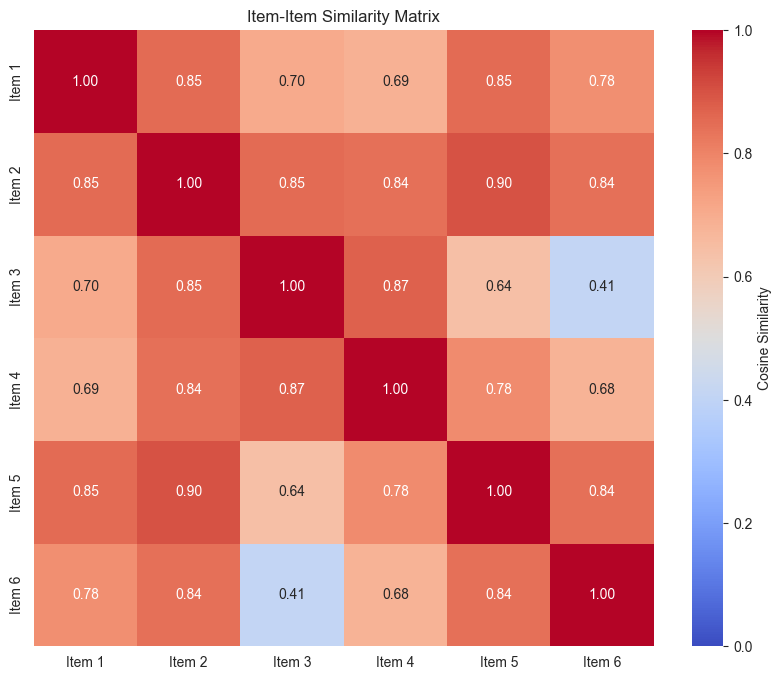

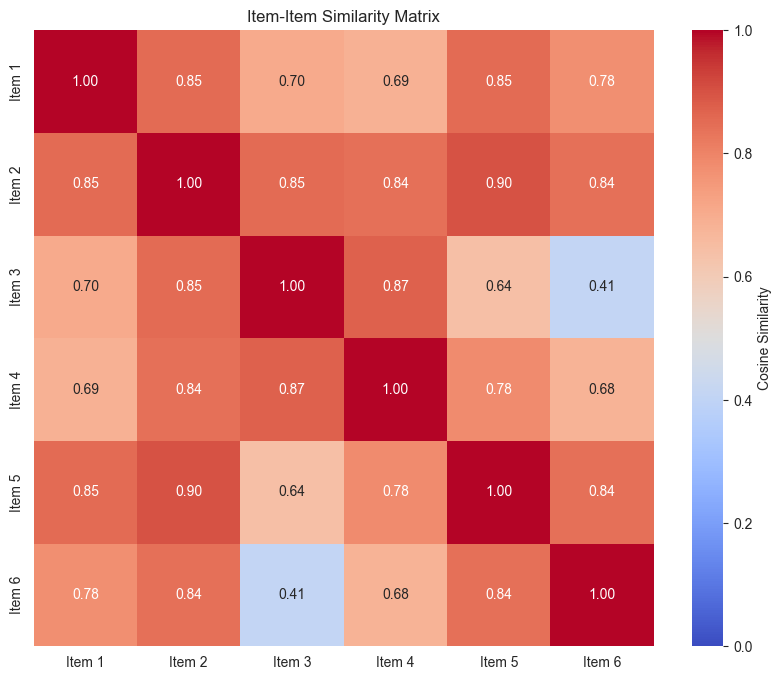

In [35]:
plot_similarity_matrix(tabelog_cf.item_similarities, title="Item-Item Similarity Matrix", label="Cosine Similarity", color_scheme="coolwarm")

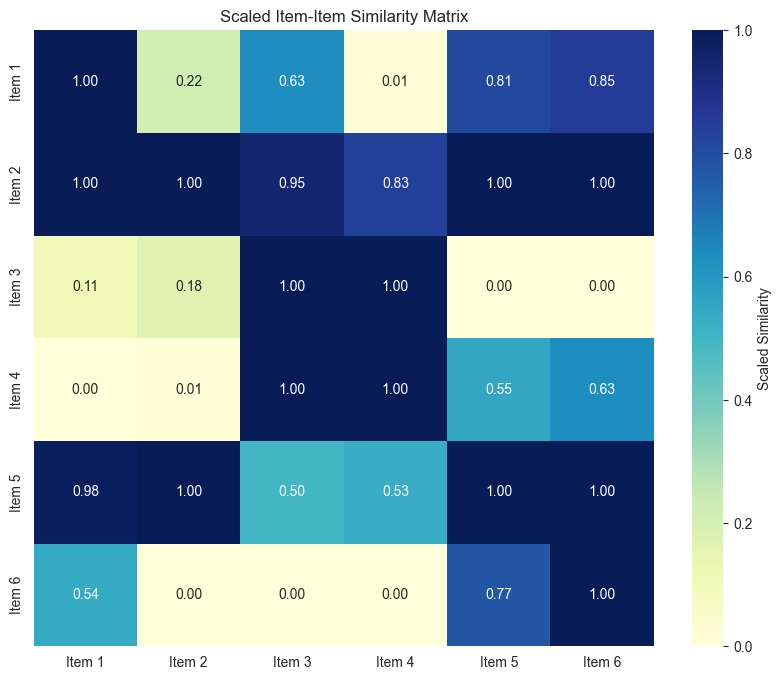

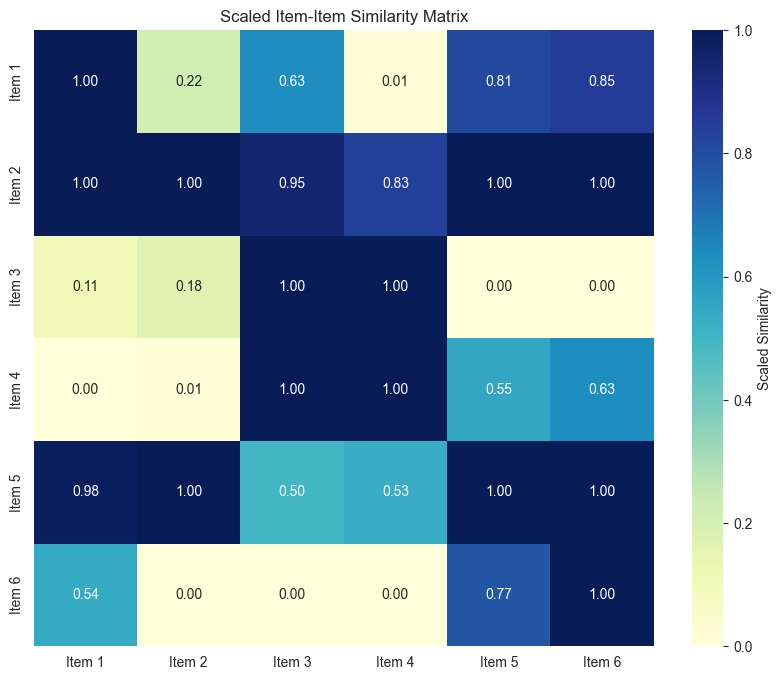

In [36]:
plot_similarity_matrix(tabelog_cf.get_ssc(), title="Scaled Item-Item Similarity Matrix", label="Scaled Similarity", color_scheme="YlGnBu")

In [37]:
def get_stats_of_cf(original_df, imputed_df, category_names):
    """
    Evaluate how diverse the predictions are in the imputed dataframe
    """
    # Calculate standard deviation of each rating category
    std_devs = {}
    for col in category_names:
        std_devs[col] = imputed_df[col].std()
    # Count unique values in each category
    unique_counts = {}
    for col in category_names:
        unique_counts[col] = len(imputed_df[col].unique())
    # Calculate the percentage of imputed values
    total_cells = len(original_df) * (len(category_names))
    original_nan_count = original_df.iloc[:, 1:].isna().sum().sum()
    imputation_percentage = (original_nan_count / total_cells) * 100
    
    return std_devs, unique_counts, imputation_percentage

In [38]:
sd, uc, ip = get_stats_of_cf(restaurant_data, predicted_df, category_names1)
print("Standard Deviations:")
for c in sd:
    print(f"{c}: {sd[c]:.2f}")
    
print("\nUnique Counts:")
for u in uc:
    print(f"{u}: {uc[u]}")

print(f"\nPercentage Imputed: {ip:.2f}%")    

Standard Deviations:
overall_rating: 0.66
food: 0.65
service: 0.69
atmosphere: 0.36
price: 0.69
drink: 0.63

Unique Counts:
overall_rating: 17
food: 15
service: 14
atmosphere: 11
price: 14
drink: 15

Percentage Imputed: 55.56%


In [39]:
# Write imputed data to CSV
predicted_df.to_csv("./data/cf_imputed_tabelog_review_data/predicted_tabelog_鎌倉のごはんやさん_石渡_review_data.csv", encoding="utf-8-sig", index=False)